In [13]:

from langgraph.graph import StateGraph,START, END
from typing import TypedDict, Literal, Annotated

from langchain_core.messages import SystemMessage, HumanMessage
import operator
import os
from dotenv import load_dotenv
from langchain_google_genai import GoogleGenerativeAI
import os
import warnings
warnings.filterwarnings("ignore")
load_dotenv()
from langchain.output_parsers import PydanticOutputParser

In [14]:
#setting up three differt LLMs

generator_LLM = GoogleGenerativeAI(
    model="gemini-2.5-pro",  
    google_api_key=os.getenv('GOOGLE_API_KEY') )

Evaluator_LLM = GoogleGenerativeAI(
    model="gemini-2.5-pro",  
    google_api_key=os.getenv('GOOGLE_API_KEY') )

Optimizer_LLM = GoogleGenerativeAI(
    model="gemini-2.5-pro",  
    google_api_key=os.getenv('GOOGLE_API_KEY') )

In [15]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")


parser_evaluation  = PydanticOutputParser(pydantic_object=TweetEvaluation)

In [16]:
def structured_evaluator_LLM_invoke(tweet:str) ->TweetEvaluation:

    prompt =(

         f"Tweet: {tweet}\n"
        "Evaluate the above tweet and respond strictly in JSON format as follows:\n"
        "{\"evaluation\": <'approved' or 'needs_improvement'>, "
        "\"feedback\": <short constructive feedback for the tweet>}\n"
        "Do not include any extra text, explanations, or markdown. Only return valid JSON."

    )

    raw_response = Evaluator_LLM.predict(prompt)
    parsed = parser_evaluation.parse(raw_response)
    return parsed

In [17]:
class Tweetstate(TypedDict):

    topic :str
    tweet :str
    evaluation :Literal["approved","needs improvement"]
    feedback :str
    iteration :int
    max_iterations :int

In [18]:
def generate_tweet(state:Tweetstate)-> Tweetstate:

    #prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    #send to generatir LLM

    response = generator_LLM.invoke(messages)


    #return response

    return  { "tweet":response}

In [19]:
def evaluate_tweet(state:Tweetstate)-> Tweetstate:

   #prompt

 messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]
     
 response = structured_evaluator_LLM_invoke(messages)


 return {'evaluation':response.evaluation,'feedback':response.feedback}
     
     

In [20]:
def route_evaluation(state: Tweetstate)->Tweetstate:

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iterations']:
        return 'approved'
    else:
        return 'needs_improvement'

In [21]:
def optimize_tweet(state:Tweetstate)->Tweetstate:

    #prompt

      messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]
      
      response = Optimizer_LLM.invoke(messages)
      iteration = state['iteration'] +  1
      
      return  {'tweet':response,'iteration':iteration}

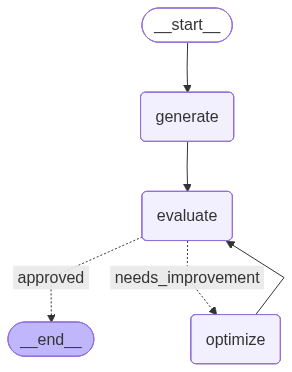

In [22]:
graph = StateGraph(Tweetstate)

graph.add_node("generate",generate_tweet)
graph.add_node("evaluate",evaluate_tweet)
graph.add_node("optimize",optimize_tweet)



graph.add_edge(START,'generate')
graph.add_edge('generate','evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'needs_improvement': 'optimize'})
graph.add_edge('optimize', 'evaluate')

workflow = graph.compile()

workflow

In [27]:


initial_state = {
    "topic": "Asshole",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

print(result)

{'topic': 'Asshole', 'tweet': "You're not a true asshole until you leave 3 seconds on the microwave. It’s not just a minor inconvenience, it’s a psychological power move. It says “I am chaos, and my work here is done.”", 'evaluation': 'approved', 'feedback': "This tweet succeeds by taking a highly relatable, mundane annoyance and reframing it with hilariously dramatic language. Calling it a 'psychological power move' and ending with the 'I am chaos' declaration gives a fresh, funny voice to a common observation. It's not a groundbreaking concept, but the execution is sharp, memorable, and built for virality.", 'iteration': 1}


In [24]:
print(result['tweet'])

My toddler and the cat have formed a sleeper cell. Their mission: to systematically destroy every roll of toilet paper in the house. I'm trying to negotiate but their demands are unreasonable.


In [25]:
print(result["evaluation"])

approved


In [26]:
print(result["feedback"])

This tweet excels by applying a high-stakes, dramatic framework ('sleeper cell,' 'negotiation') to a mundane and highly relatable domestic problem. The humor is built through this juxtaposition, and the final line about 'unreasonable demands' serves as an excellent punchline that reinforces the central gag. It's original, well-paced, and perfectly formatted for virality among parents and pet owners.
